In [17]:
import numpy as np
import matplotlib.pyplot as plt
import struct

In [113]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [114]:
data = read_idx('./data/train-images.idx3-ubyte')

In [115]:
train_labels = read_idx('./data/train-labels.idx1-ubyte')

In [116]:
data = data.reshape(60000, 28*28)

In [117]:
train_labels[55]

8

In [118]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [119]:
class Layer:
    def __init__(self, input_size, size, activation_function, activation_prime, W=None, b=None, init=None):
        self.size = size
        if W == None:
            if init == None:
                self.W = np.random.normal(0, 0.01, (size, input_size))
        else:
            self.W = W
        self.b = np.zeros(size)
        self.func = activation_function
        
    def predict(self, input):
        self.z = self.b + self.W.dot(input)
        self.a = self.func(self.z)
        return self.a
    
    def backprop(self, a):
        pass

In [130]:
class MLP:
    def __init__(self, input_size, output_size, *layers, learning_rate = 0.001, batch_size = 100):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        self.hidden_layers = layers
        self.input_layer = Layer(input_size, self.hidden_layers[0].size, lambda x:x, lambda x:1, W=np.ones((size, input_size)), )
        self.output_layer = Layer(self.hidden_layers[-1].size, self.output_size, softmax, np.tanh)
        self.layers = (self.input_layer,) + self.hidden_layers + (self.output_layer,)
    
    def predict(self, input):
        a = input
        for f in self.layers:
            a = f.predict(a)
        return a
    
    def loss(self, x, y):
        return -(y * np.log(self.predict(x))).sum()
    
    def delta_output(self, x, y):
        return self.predict(x) - y

In [131]:
hl = Layer(28*28, 28*28, np.tanh, lambda x:1-np.tanh(x)**2)

In [132]:
mlp = MLP(28*28, 10, hl)

In [133]:
np.log(mlp.predict(data[55]))

array([-2.44780038, -2.58014512, -2.03436307, -2.23968144, -2.79346333,
       -2.42249112, -1.79083619, -2.52725276, -2.17994441, -2.39864036])

<Container object of 10 artists>

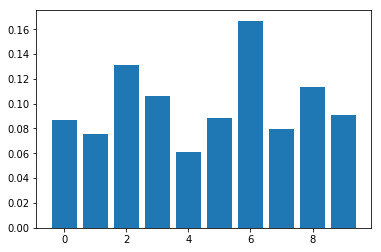

In [134]:
plt.bar(range(10), mlp.predict(data[55]))

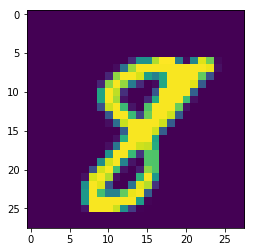

In [135]:
plt.imshow(data[55].reshape((28,28)))

In [136]:
y = np.array([0,0,0,0,0,0,0,0,1,0])

In [137]:
mlp.loss(data[48], y)

2.561325877821967

In [142]:
f = lambda x:1

In [143]:
f(1)

1